In [113]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow transformers mplfinance

In [114]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import os
import glob

In [115]:
ticker = "NVDA"
start_date = "2023-01-01"
end_date = "2024-01-01"
stock_data = yf.download(ticker, start=start_date, end=end_date)
data = stock_data
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2023-01-03,14.304595,14.985101,14.085754,14.840206,401277000
2023-01-04,14.738280,14.842205,14.230650,14.556413,431324000
2023-01-05,14.254631,14.553413,14.137716,14.480467,389168000
2023-01-06,14.848200,14.999090,14.023800,14.463479,405044000
2023-01-09,15.616641,16.044329,15.129995,15.272891,504231000


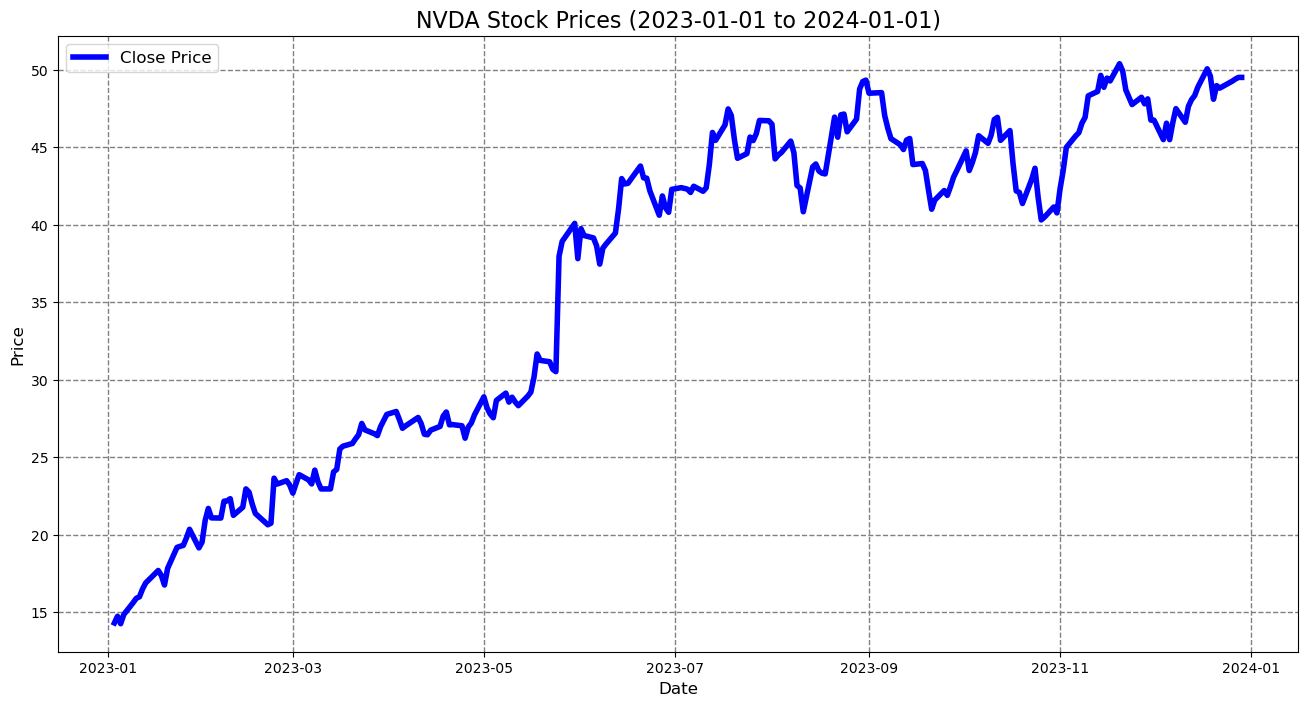

In [116]:
plt.figure(figsize=(16,8))
plt.plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=4)
plt.title(f'{ticker} Stock Prices ({start_date} to {end_date})', fontsize=16)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Price', fontsize = 12)
plt.grid(color = 'gray', linestyle='--', linewidth=1)
plt.legend(fontsize = 12)
plt.show()

In [117]:
#gets all the .PNG files within the same directory/folder
images = glob.glob('*.PNG')
print(images)
patterns = []
image_data = []

for img in images:
    imgs = Image.open(img).convert('RGB').resize((150, 150))
    img_array = np.array(imgs)/255.0
    image_data.append(img_array)
    filename = os.path.basename(img)
    if 'bullish_flag' in filename:
        patterns.append('bullish_flag')
    elif 'bearish_wedge' in filename:
        patterns.append('bearish_wedge')
    elif 'double_top' in filename:
        patterns.append('double_top')
    elif 'double_bot' in filename:
        patterns.append('double_bot')
    elif 'triple_top' in filename:
        patterns.append('triple_top')
    elif 'triple_bot' in filename:
        patterns.append('triple_bot')

image_data = np.array(image_data)
patterns = np.array(patterns)

print(patterns)

['bearish_wedge.PNG', 'bullish_flag.PNG', 'double_bot.PNG', 'double_top.PNG', 'triple_bot.PNG', 'triple_top.PNG']
['bearish_wedge' 'bullish_flag' 'double_bot' 'double_top' 'triple_bot'
 'triple_top']


In [118]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

label_encoder = LabelEncoder()
encoded_patterns = label_encoder.fit_transform(patterns)


y = to_categorical(encoded_patterns)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

augmented_images = []
augmented_labels = []

for img, label in zip(image_data, patterns):
    img = np.expand_dims(img, axis=0)  
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        i += 1
        if i >= 20:  
            break


augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

image_data = np.concatenate((image_data, augmented_images), axis=0)
patterns = np.concatenate((patterns, augmented_labels), axis=0)

label_encoder = LabelEncoder()
encoded_patterns = label_encoder.fit_transform(patterns)
y = to_categorical(encoded_patterns)



In [119]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, y, test_size = .20, random_state = 32)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 150, 150, 3)
(26, 150, 150, 3)
(100, 6)
(26, 6)


In [120]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

CNN_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(y.shape[1], activation='softmax')
])

CNN_model.compile(optimizer=Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])


trained_model = CNN_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

CNN_model.save('pattern_recognizer.keras')

Epoch 1/50


C:\Users\azeel\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.1539 - loss: 2.0179 - val_accuracy: 0.2308 - val_loss: 1.9803
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.1541 - loss: 2.0882 - val_accuracy: 0.1538 - val_loss: 1.9622
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.1802 - loss: 1.9824 - val_accuracy: 0.1923 - val_loss: 1.9550
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.1263 - loss: 1.9881 - val_accuracy: 0.1923 - val_loss: 1.9467
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.2097 - loss: 1.9506 - val_accuracy: 0.3077 - val_loss: 1.9340
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.2497 - loss: 1.9124 - val_accuracy: 0.3462 - val_loss: 1.9123
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.2519 - loss: 1.9051 - val_accuracy: 0.1923 - val_loss: 1.8891
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.3395 - loss: 1.8226 - val_accuracy: 0.1923 - val_loss: 1.8842
Epo

In [121]:
import yfinance as yf

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


def predict_stock_pattern(image_path, model, label_encoder):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    class_idx = np.argmax(prediction)
    pattern = label_encoder.inverse_transform([class_idx])[0]
    confidence_scores = {label: score for label, score in zip(label_encoder.classes_, prediction[0])}
    print(f"Prediction confidence: {confidence_scores}")
    return pattern


def analyze_stock(ticker, start_date, end_date, model, label_encoder):
    data = yf.download(ticker, start=start_date, end=end_date)
    
    
    plt.figure(figsize=(16,8))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=4)
    plt.title(f'{ticker} Stock Prices ({start_date} to {end_date})', fontsize=16)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Price', fontsize = 12)
    plt.grid(color = 'gray', linestyle='--', linewidth=1)
    plt.legend(fontsize = 12)
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    chart_path = f"{ticker}_chart.png"
    plt.savefig(chart_path)  
    plt.close()  
    
    predicted_pattern = predict_stock_pattern(chart_path, model, label_encoder)  
    return predicted_pattern

from tensorflow.keras.models import load_model

CNN_model = load_model('pattern_recognizer.keras')  
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['bullish_flag', 'bearish_wedge', 'double_top', 'double_bot', 'triple_top', 'triple_bot'])


ticker = "NVDA"
start_date = "2023-01-01"
end_date = "2024-01-01"
predicted_pattern = analyze_stock(ticker, start_date, end_date, CNN_model, label_encoder)
print(f"The predicted pattern for {ticker} is: {predicted_pattern}")

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction confidence: {'bullish_flag': 0.059548635, 'bearish_wedge': 0.64741117, 'double_top': 0.08169927, 'double_bot': 0.04343429, 'triple_top': 0.042038586, 'triple_bot': 0.12586805}
The predicted pattern for NVDA is: bearish_wedge
